# Gemma2-27B MLP Interpretation

This notebook analyzes how PC vectors transform through the full MLP forward pass, including nonlinear activations.

**Key Finding from Original Analysis:**
- **Layer 18 is the "smoking gun"** - shows strongest PC1 transformation effects
- Full MLP pass reveals semantic decomposition that linear analysis misses

**Approach:**
1. Run PC vectors through complete MLP (pre_ln → gate/up → down → post_ln)
2. Compare base vs instruct outputs
3. Decompose outputs onto role/trait semantic vectors
4. Focus on layer 18 for detailed interpretation

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_individual_role_vectors,
    load_individual_trait_vectors,
    normalize_vector,
    full_mlp_forward_batch,
    compute_z_scores
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Models and PC Vectors

In [2]:
# Load models (reuse from basic_weight_susceptibility or reload)
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
base_state_dict = {k: v.cpu() for k, v in base_model.state_dict().items()}
instruct_state_dict = {k: v.cpu() for k, v in instruct_model.state_dict().items()}
print("✓ Models loaded")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [3]:
# Load PCA data and extract all PCs
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"
roles_vectors_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "vectors"
traits_vectors_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "vectors"

pca_data, _ = load_pca_data(roles_pca_dir)
pca_layer = pca_data['layer']

# Extract ALL PCs (load 10 for flexibility)
n_pcs_total = 10
pcs_all, variance_all = extract_pc_components(pca_data, n_components=n_pcs_total)

print(f"✓ Loaded PCA data from layer {pca_layer}")
print(f"  Extracted {n_pcs_total} PCs")
print(f"  Variance explained by first 5: {variance_all[:5]}")

# Load all semantic vectors at PCA layer
role_vectors = load_individual_role_vectors(roles_vectors_dir, pca_layer)
trait_vectors = load_individual_trait_vectors(traits_vectors_dir, pca_layer)
all_semantic = {**role_vectors, **trait_vectors}

print(f"\n✓ Loaded semantic vectors:")
print(f"  {len(role_vectors)} role difference vectors")
print(f"  {len(trait_vectors)} trait contrast vectors")
print(f"  {len(all_semantic)} total semantic vectors")

/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ Loaded PCA data from layer 22
  Extracted 10 PCs
  Variance explained by first 5: [0.21216452 0.08200892 0.06822039 0.05221459 0.04578365]

✓ Loaded semantic vectors:
  275 role difference vectors
  240 trait contrast vectors
  506 total semantic vectors


In [4]:
# ============================================================================
# CONFIGURATION: Set analysis parameters here
# ============================================================================

# Which layers to analyze (focused on middle layers where effects are strongest)
analysis_layers = list(range(15, 25))

# Which PCs to visualize in plots
plot_pcs = ["PC1", "-PC1"]
# plot_pcs = ["PC1"]  # Uncomment to focus on PC1 only

# Number of top semantic projections to show
n_top_projections = 15

# Focus layers will be automatically identified:
# - focus_layer_absolute: Layer with biggest absolute delta (L2 norm)
# - focus_layer_angular: Layer with biggest angular delta (cosine distance)

print(f"📋 Analysis Configuration:")
print(f"  Analyzing layers: {analysis_layers[0]}-{analysis_layers[-1]}")
print(f"  Visualizing PCs: {plot_pcs}")
print(f"  Top projections to show: {n_top_projections}")
print(f"  Focus layers will be auto-identified from data")

📋 Analysis Configuration:
  Analyzing layers: 17-26
  Focus layer for semantic decomposition: 18
  Visualizing PCs: ['PC1', '-PC1']
  Top projections to show: 15


## 2. Full MLP Forward Pass Analysis

In [13]:
# Run MLP analysis for configured layers
mlp_results = []

print(f"Running MLP forward pass for layers {analysis_layers[0]}-{analysis_layers[-1]}...")

# Prepare input vectors (configured PCs)
input_vectors = []
vector_names = []

for pc_name in plot_pcs:
    if pc_name.startswith('-'):
        # Negative PC
        pc_idx = int(pc_name[3:]) - 1  # Extract number from "-PC1"
        vec = -pcs_all[pc_idx].float()
    else:
        # Positive PC
        pc_idx = int(pc_name[2:]) - 1  # Extract number from "PC1"
        vec = pcs_all[pc_idx]
    
    input_vectors.append(vec)
    vector_names.append(pc_name)

vectors_batch = torch.stack(input_vectors)

# Store full outputs for angular delta calculation
layer_outputs_base = {}
layer_outputs_inst = {}

for layer_num in tqdm(analysis_layers):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    # Forward pass through base and instruct
    with torch.inference_mode():
        output_base = full_mlp_forward_batch(vectors_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        output_inst = full_mlp_forward_batch(vectors_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Store for angular analysis
    layer_outputs_base[layer_num] = output_base
    layer_outputs_inst[layer_num] = output_inst
    
    # Compute norms and deltas for each vector
    for i, vec_name in enumerate(vector_names):
        base_norm = output_base[i].float().norm().item()
        inst_norm = output_inst[i].float().norm().item()
        
        # Absolute delta (L2 norm of difference)
        delta_vec = output_inst[i] - output_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta (cosine distance)
        # Cosine similarity: (a·b) / (||a|| ||b||)
        # Cosine distance: 1 - cosine_similarity
        dot_product = (output_base[i].float() @ output_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        mlp_results.append({
            'layer': layer_num,
            'input_vector': vec_name,
            'base_output_norm': base_norm,
            'instruct_output_norm': inst_norm,
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

mlp_df = pd.DataFrame(mlp_results)
print(f"\n✓ MLP analysis complete: {len(mlp_df)} results")

# Identify focus layers (using first PC)
first_pc = plot_pcs[0]
first_pc_data = mlp_df[mlp_df['input_vector'] == first_pc]

focus_layer_absolute_idx = first_pc_data['delta_absolute'].idxmax()
focus_layer_absolute = first_pc_data.loc[focus_layer_absolute_idx, 'layer']

focus_layer_angular_idx = first_pc_data['delta_angular'].idxmax()
focus_layer_angular = first_pc_data.loc[focus_layer_angular_idx, 'layer']

print(f"\n🎯 Focus layers identified (for {first_pc}):")
print(f"  Absolute delta (L2 norm): Layer {focus_layer_absolute} (Δ={first_pc_data.loc[focus_layer_absolute_idx, 'delta_absolute']:.4f})")
print(f"  Angular delta (cosine distance): Layer {focus_layer_angular} (Δ={first_pc_data.loc[focus_layer_angular_idx, 'delta_angular']:.4f})")

Running MLP forward pass for layers 17-26...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


✓ MLP analysis complete: 20 results

🎯 Focus layers identified (for PC1):
  Absolute delta (L2 norm): Layer 24 (Δ=678.7557)
  Angular delta (cosine distance): Layer 18 (Δ=0.0854)


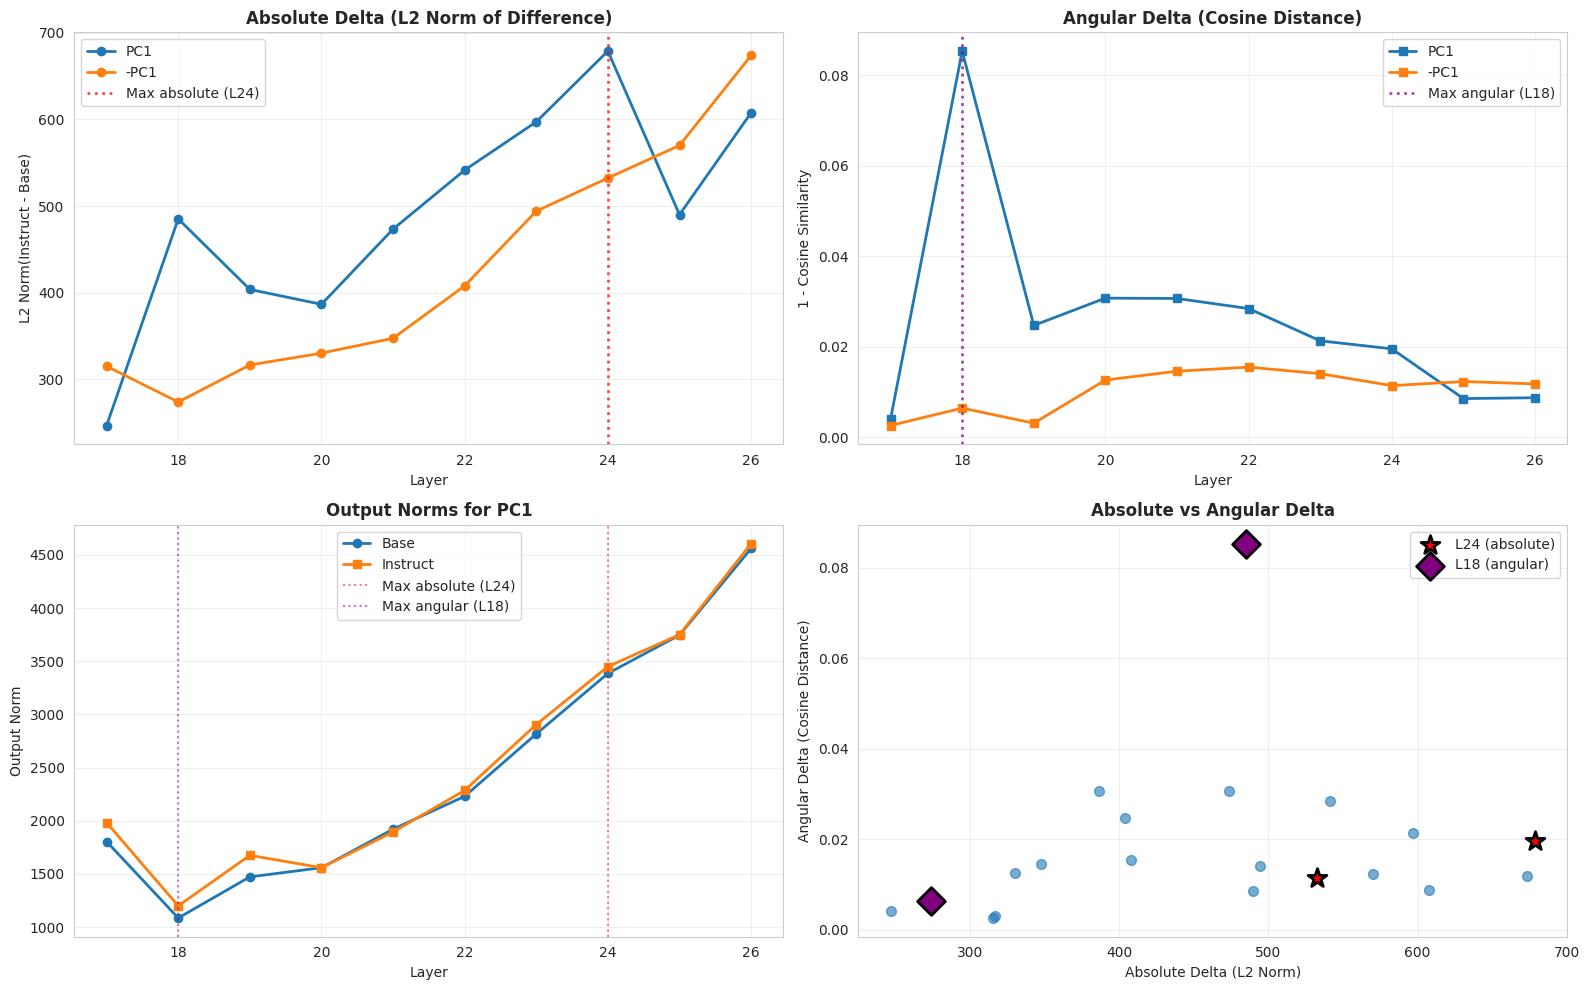


📊 Visualization shows:
  - Red markers: Layer 24 (max absolute delta)
  - Purple markers: Layer 18 (max angular delta)
  ⚠ Different layers identified - analyzing both!


In [14]:
# Visualize MLP transformation results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Absolute delta by layer (top left)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 0].plot(data['layer'], data['delta_absolute'], marker='o', label=vec_name, linewidth=2)

axes[0, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[0, 0].set_title('Absolute Delta (L2 Norm of Difference)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Layer')
axes[0, 0].set_ylabel('L2 Norm(Instruct - Base)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Angular delta by layer (top right)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 1].plot(data['layer'], data['delta_angular'], marker='s', label=vec_name, linewidth=2)

axes[0, 1].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.7, linewidth=2, label=f'Max angular (L{int(focus_layer_angular)})')
axes[0, 1].set_title('Angular Delta (Cosine Distance)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('1 - Cosine Similarity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Compare base vs instruct norms (bottom left, first PC only)
first_pc = plot_pcs[0]
pc_data = mlp_df[mlp_df['input_vector'] == first_pc]
axes[1, 0].plot(pc_data['layer'], pc_data['base_output_norm'], marker='o', label='Base', linewidth=2, color='C0')
axes[1, 0].plot(pc_data['layer'], pc_data['instruct_output_norm'], marker='s', label='Instruct', linewidth=2, color='C1')
axes[1, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[1, 0].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5, label=f'Max angular (L{int(focus_layer_angular)})')
axes[1, 0].set_title(f'Output Norms for {first_pc}', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Output Norm')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: Absolute vs Angular delta (bottom right)
axes[1, 1].scatter(mlp_df['delta_absolute'], mlp_df['delta_angular'], alpha=0.6, s=50)
# Highlight focus layers
for vec_name in plot_pcs:
    vec_data = mlp_df[mlp_df['input_vector'] == vec_name]
    abs_focus = vec_data[vec_data['layer'] == focus_layer_absolute]
    ang_focus = vec_data[vec_data['layer'] == focus_layer_angular]
    
    if not abs_focus.empty:
        axes[1, 1].scatter(abs_focus['delta_absolute'], abs_focus['delta_angular'], 
                          color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                          label=f'L{int(focus_layer_absolute)} (absolute)' if vec_name == first_pc else '')
    if not ang_focus.empty:
        axes[1, 1].scatter(ang_focus['delta_absolute'], ang_focus['delta_angular'], 
                          color='purple', s=200, marker='D', edgecolors='black', linewidths=2,
                          label=f'L{int(focus_layer_angular)} (angular)' if vec_name == first_pc else '')

axes[1, 1].set_title('Absolute vs Angular Delta', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Absolute Delta (L2 Norm)')
axes[1, 1].set_ylabel('Angular Delta (Cosine Distance)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization shows:")
print(f"  - Red markers: Layer {int(focus_layer_absolute)} (max absolute delta)")
print(f"  - Purple markers: Layer {int(focus_layer_angular)} (max angular delta)")
if focus_layer_absolute == focus_layer_angular:
    print(f"  ✓ Both metrics identify the same layer!")
else:
    print(f"  ⚠ Different layers identified - analyzing both!")

## 3. Semantic Decomposition at Focus Layers

Decompose what instruction tuning adds at both focus layers:
- **Absolute focus layer**: Where magnitude change is largest
- **Angular focus layer**: Where direction change is largest

In [15]:
def analyze_focus_layer(layer_num, layer_name, first_pc_name, pc_idx):
    """Analyze semantic decomposition at a focus layer."""
    print(f"\n{'='*80}")
    print(f"{layer_name.upper()}: Layer {layer_num}")
    print(f"{'='*80}")
    
    # Get PC vector
    if first_pc_name.startswith('-'):
        pc_vec = -pcs_all[pc_idx].float()
    else:
        pc_vec = pcs_all[pc_idx]
    
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        pc_batch = pc_vec.unsqueeze(0)
        output_base = full_mlp_forward_batch(pc_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)[0]
        output_inst = full_mlp_forward_batch(pc_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)[0]
    
    # Compute difference
    difference = output_inst - output_base
    
    # Compute metrics
    base_norm = output_base.float().norm().item()
    inst_norm = output_inst.float().norm().item()
    diff_norm = difference.float().norm().item()
    
    dot_product = (output_base.float() @ output_inst.float()).item()
    cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
    cosine_dist = 1.0 - cosine_sim
    
    print(f"\n{first_pc_name} MLP transformation:")
    print(f"  Base output norm: {base_norm:.4f}")
    print(f"  Instruct output norm: {inst_norm:.4f}")
    print(f"  Absolute delta (L2): {diff_norm:.4f}")
    print(f"  Angular delta (cosine dist): {cosine_dist:.4f}")
    
    # Project difference onto semantic vectors
    semantic_names = list(all_semantic.keys())
    projections = {}
    for name in semantic_names:
        vec = all_semantic[name]
        proj = (difference.float() @ vec.float()).item()
        projections[name] = proj
    
    # Sort by strength
    sorted_projs = sorted(projections.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n🔍 Top {n_top_projections} semantic projections (what instruction tuning adds):")
    print("-"*80)
    for name, proj in sorted_projs[:n_top_projections]:
        print(f"{proj:+.4f}  {name}")
    
    print(f"\n🔍 Bottom {n_top_projections} semantic projections:")
    print("-"*80)
    for name, proj in sorted_projs[-n_top_projections:]:
        print(f"{proj:+.4f}  {name}")
    
    return sorted_projs

# Prepare PC info
first_pc_name = plot_pcs[0]
if first_pc_name.startswith('-'):
    pc_idx = int(first_pc_name[3:]) - 1
else:
    pc_idx = int(first_pc_name[2:]) - 1

In [16]:
# Analyze absolute focus layer
projections_absolute = analyze_focus_layer(
    int(focus_layer_absolute),
    "ABSOLUTE FOCUS LAYER",
    first_pc_name,
    pc_idx
)


ABSOLUTE FOCUS LAYER: Layer 24

PC1 MLP transformation:
  Base output norm: 3386.0586
  Instruct output norm: 3450.4001
  Absolute delta (L2): 677.9233
  Angular delta (cosine dist): 0.0195

🔍 Top 15 semantic projections (what instruction tuning adds):
--------------------------------------------------------------------------------
-387.2055  poet
-387.2017  poetic
-378.3598  pirate
-365.1915  bard
-359.6892  grandparent
-358.5293  jester
-355.9594  provincial
-355.3169  prisoner
-354.9160  narrator
-354.6192  celebrity
-354.3450  criminal
-354.0408  blogger
-354.0311  auctioneer
-352.6799  survivor
-348.8299  elder

🔍 Bottom 15 semantic projections:
--------------------------------------------------------------------------------
+16.2677  data_driven
+13.4563  erudite
+13.2695  lawyer
+13.2139  cyborg
+12.4775  proofreader
-12.0521  sociologist
+10.9182  negotiator
-10.7981  proactive
+9.9051  closure_seeking
-5.5777  pragmatist
-4.5826  interviewer
+3.5088  divergent
+3.0071  skepti

In [17]:
# Analyze angular focus layer
projections_angular = analyze_focus_layer(
    int(focus_layer_angular),
    "ANGULAR FOCUS LAYER",
    first_pc_name,
    pc_idx
)


ANGULAR FOCUS LAYER: Layer 18

PC1 MLP transformation:
  Base output norm: 1085.9705
  Instruct output norm: 1199.4109
  Absolute delta (L2): 485.7257
  Angular delta (cosine dist): 0.0853

🔍 Top 15 semantic projections (what instruction tuning adds):
--------------------------------------------------------------------------------
-374.8465  poet
-358.6617  poetic
-354.5849  pirate
-340.0732  provincial
-338.4370  bard
-338.1057  jester
-335.1357  auctioneer
-333.2851  prisoner
-329.1964  criminal
-328.2269  blogger
-327.1615  grandparent
-325.5511  gossip
-325.5268  narrator
-323.7765  comedian
-323.3954  adolescent

🔍 Bottom 15 semantic projections:
--------------------------------------------------------------------------------
+9.3190  skeptic
-9.2563  sociologist
-7.9323  geographer
+6.6415  summarizer
-5.6977  generalist
+5.6200  moderator
-5.1247  submissive
-3.8993  meditative
+2.9690  supervisor
-2.8424  negotiator
-2.5092  facilitator
-2.2224  data_driven
+1.3163  mediator
+

## 3.5. Extended Analysis: All Semantic Vectors

Analyze how instruction tuning affects all role and trait vectors, and examine PC self-reinforcement patterns.

In [18]:
# Run all semantic vectors through MLP at both focus layers
print(f"Computing MLP transformations for {len(all_semantic)} semantic vectors...")
print(f"  Analyzing at absolute focus layer: {int(focus_layer_absolute)}")
print(f"  Analyzing at angular focus layer: {int(focus_layer_angular)}")

semantic_results = []

# Prepare all semantic vectors
semantic_names = list(all_semantic.keys())
semantic_vectors = torch.stack([all_semantic[name] for name in semantic_names])

for layer_num in [int(focus_layer_absolute), int(focus_layer_angular)]:
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        outputs_base = full_mlp_forward_batch(semantic_vectors, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        outputs_inst = full_mlp_forward_batch(semantic_vectors, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Compute deltas for each semantic vector
    for i, name in enumerate(semantic_names):
        base_norm = outputs_base[i].float().norm().item()
        inst_norm = outputs_inst[i].float().norm().item()
        
        # Absolute delta
        delta_vec = outputs_inst[i] - outputs_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta
        dot_product = (outputs_base[i].float() @ outputs_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        # Determine type
        if name in role_vectors:
            vec_type = "role"
        elif name in trait_vectors:
            vec_type = "trait"
        else:
            vec_type = "other"
        
        semantic_results.append({
            'name': name,
            'type': vec_type,
            'layer': layer_num,
            'layer_type': 'absolute' if layer_num == int(focus_layer_absolute) else 'angular',
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

semantic_df = pd.DataFrame(semantic_results)
print(f"\n✓ Computed transformations for {len(semantic_names)} vectors at 2 layers")
print(f"  Total results: {len(semantic_df)}")

Computing MLP transformations for 506 semantic vectors...
  Analyzing at absolute focus layer: 24
  Analyzing at angular focus layer: 18

✓ Computed transformations for 506 vectors at 2 layers
  Total results: 1012


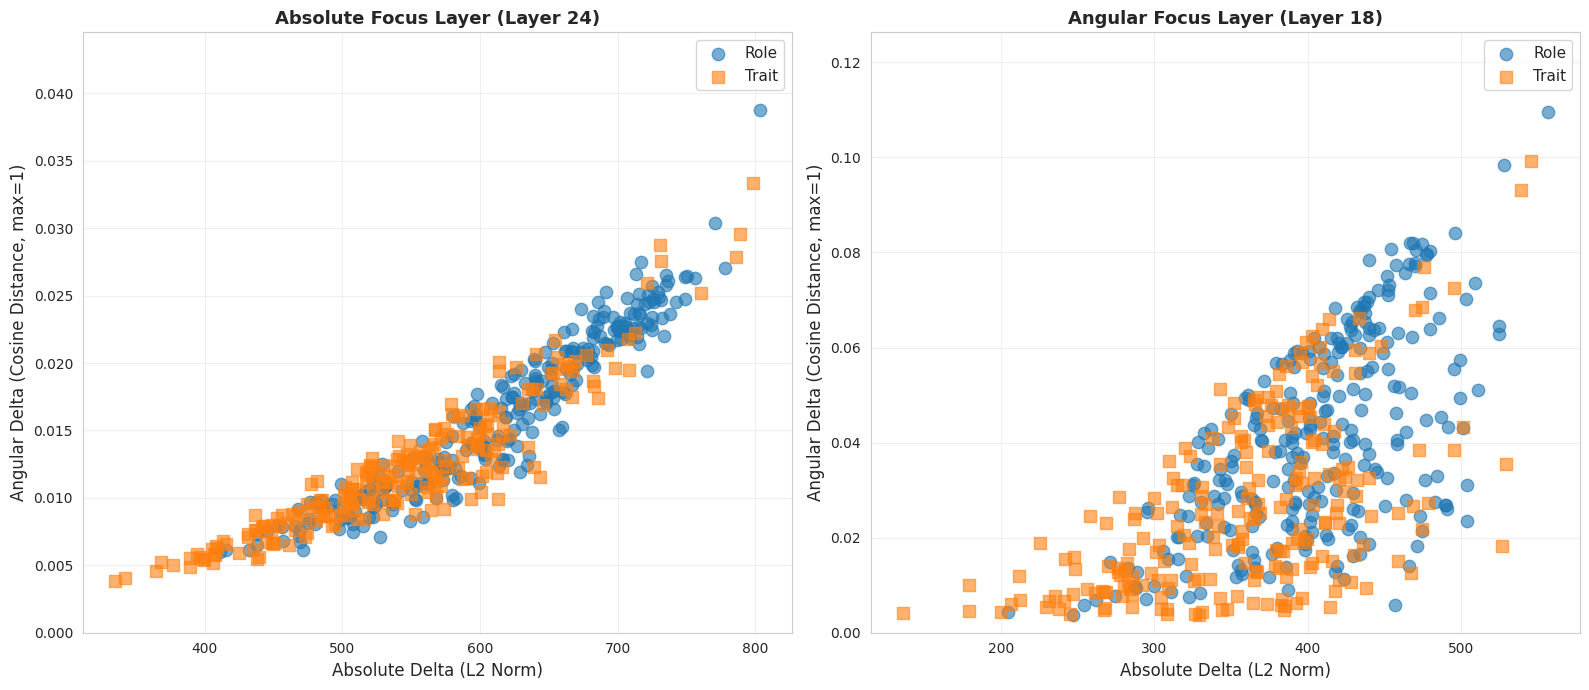


📊 Semantic Vector Shift Statistics:

Absolute Focus Layer (L24):
  Roles (n=275):
    Absolute delta: 616.6328 ± 82.8892
      Range: [411.3256, 803.3220]
    Angular delta: 0.016443 ± 0.005943
      Range: [0.005955, 0.038736]
    Correlation (abs vs ang): 0.947
  Traits (n=231):
    Absolute delta: 545.8741 ± 87.3656
      Range: [334.6776, 798.5318]
    Angular delta: 0.012295 ± 0.004991
      Range: [0.003866, 0.033382]
    Correlation (abs vs ang): 0.922

Angular Focus Layer (L18):
  Roles (n=275):
    Absolute delta: 404.5587 ± 58.0972
      Range: [204.6028, 556.5608]
    Angular delta: 0.040932 ± 0.020725
      Range: [0.003672, 0.109533]
    Correlation (abs vs ang): 0.603
  Traits (n=231):
    Absolute delta: 358.6205 ± 70.6559
      Range: [136.3863, 545.8246]
    Angular delta: 0.026658 ± 0.018438
      Range: [0.003690, 0.099150]
    Correlation (abs vs ang): 0.565


In [ ]:
# Scatter plot: Traits and Roles by shift magnitude
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for layer_idx, (layer_num, layer_type) in enumerate([
    (int(focus_layer_absolute), 'Absolute Focus Layer'),
    (int(focus_layer_angular), 'Angular Focus Layer')
]):
    ax = axes[layer_idx]
    layer_data = semantic_df[semantic_df['layer'] == layer_num]
    
    # Plot roles and traits separately
    for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
        data = layer_data[layer_data['type'] == vec_type]
        ax.scatter(data['delta_absolute'], data['delta_angular'], 
                  alpha=0.6, s=80, color=color, marker=marker, label=vec_type.capitalize())
    
    ax.set_xlabel('Absolute Delta (L2 Norm)', fontsize=12)
    ax.set_ylabel('Angular Delta (Cosine Distance,)', fontsize=12)
    ax.set_title(f'{layer_type} (Layer {layer_num})', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set reasonable y-axis limit for cosine distance
    ax.set_ylim(bottom=0, top=min(1.0, ax.get_ylim()[1] * 1.1))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Semantic Vector Shift Statistics:")
for layer_num, layer_type in [
    (int(focus_layer_absolute), 'Absolute'),
    (int(focus_layer_angular), 'Angular')
]:
    layer_data = semantic_df[semantic_df['layer'] == layer_num]
    print(f"\n{layer_type} Focus Layer (L{layer_num}):")
    for vec_type in ['role', 'trait']:
        data = layer_data[layer_data['type'] == vec_type]
        print(f"  {vec_type.capitalize()}s (n={len(data)}):")
        print(f"    Absolute delta: {data['delta_absolute'].mean():.4f} ± {data['delta_absolute'].std():.4f}")
        print(f"      Range: [{data['delta_absolute'].min():.4f}, {data['delta_absolute'].max():.4f}]")
        print(f"    Angular delta: {data['delta_angular'].mean():.6f} ± {data['delta_angular'].std():.6f}")
        print(f"      Range: [{data['delta_angular'].min():.6f}, {data['delta_angular'].max():.6f}]")
        print(f"    Correlation (abs vs ang): {data['delta_absolute'].corr(data['delta_angular']):.3f}")

## 3.6. PC Self-Reinforcement Analysis

Analyze whether PCs and their negatives tend to strengthen themselves (self-bias in outputs).

In [20]:
# Analyze PC self-reinforcement
# For each PC, measure how much the output projects back onto itself
print(f"Analyzing PC self-reinforcement across layers {analysis_layers[0]}-{analysis_layers[-1]}...")

pc_reinforcement_results = []

# Test PCs and their negatives
pc_test_vectors = []
pc_test_names = []

for pc_idx in range(min(5, n_pcs_total)):  # Test first 5 PCs
    pc_name = f"PC{pc_idx+1}"
    pc_test_vectors.append(pcs_all[pc_idx])
    pc_test_names.append(pc_name)
    
    pc_test_vectors.append(-pcs_all[pc_idx].float())
    pc_test_names.append(f"-{pc_name}")

pc_test_batch = torch.stack(pc_test_vectors)

for layer_num in tqdm(analysis_layers, desc="Computing self-reinforcement"):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        outputs_base = full_mlp_forward_batch(pc_test_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        outputs_inst = full_mlp_forward_batch(pc_test_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Compute self-projection for each PC
    for i, pc_name in enumerate(pc_test_names):
        input_vec = pc_test_batch[i]
        
        # Project outputs onto input direction
        input_norm = input_vec.float().norm()
        
        proj_base = (outputs_base[i].float() @ input_vec.float()).item() / (input_norm.item() + 1e-8)
        proj_inst = (outputs_inst[i].float() @ input_vec.float()).item() / (input_norm.item() + 1e-8)
        
        # Also compute orthogonal component (how much output is NOT in input direction)
        output_base_norm = outputs_base[i].float().norm().item()
        output_inst_norm = outputs_inst[i].float().norm().item()
        
        ortho_base = np.sqrt(max(0, output_base_norm**2 - proj_base**2))
        ortho_inst = np.sqrt(max(0, output_inst_norm**2 - proj_inst**2))
        
        pc_reinforcement_results.append({
            'pc': pc_name,
            'layer': layer_num,
            'proj_base': proj_base,
            'proj_inst': proj_inst,
            'proj_delta': proj_inst - proj_base,
            'ortho_base': ortho_base,
            'ortho_inst': ortho_inst,
            'ortho_delta': ortho_inst - ortho_base,
        })

pc_reinforce_df = pd.DataFrame(pc_reinforcement_results)
print(f"\n✓ Computed self-reinforcement for {len(pc_test_names)} PCs across {len(analysis_layers)} layers")

Analyzing PC self-reinforcement across layers 17-26...


Computing self-reinforcement: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


✓ Computed self-reinforcement for 10 PCs across 10 layers


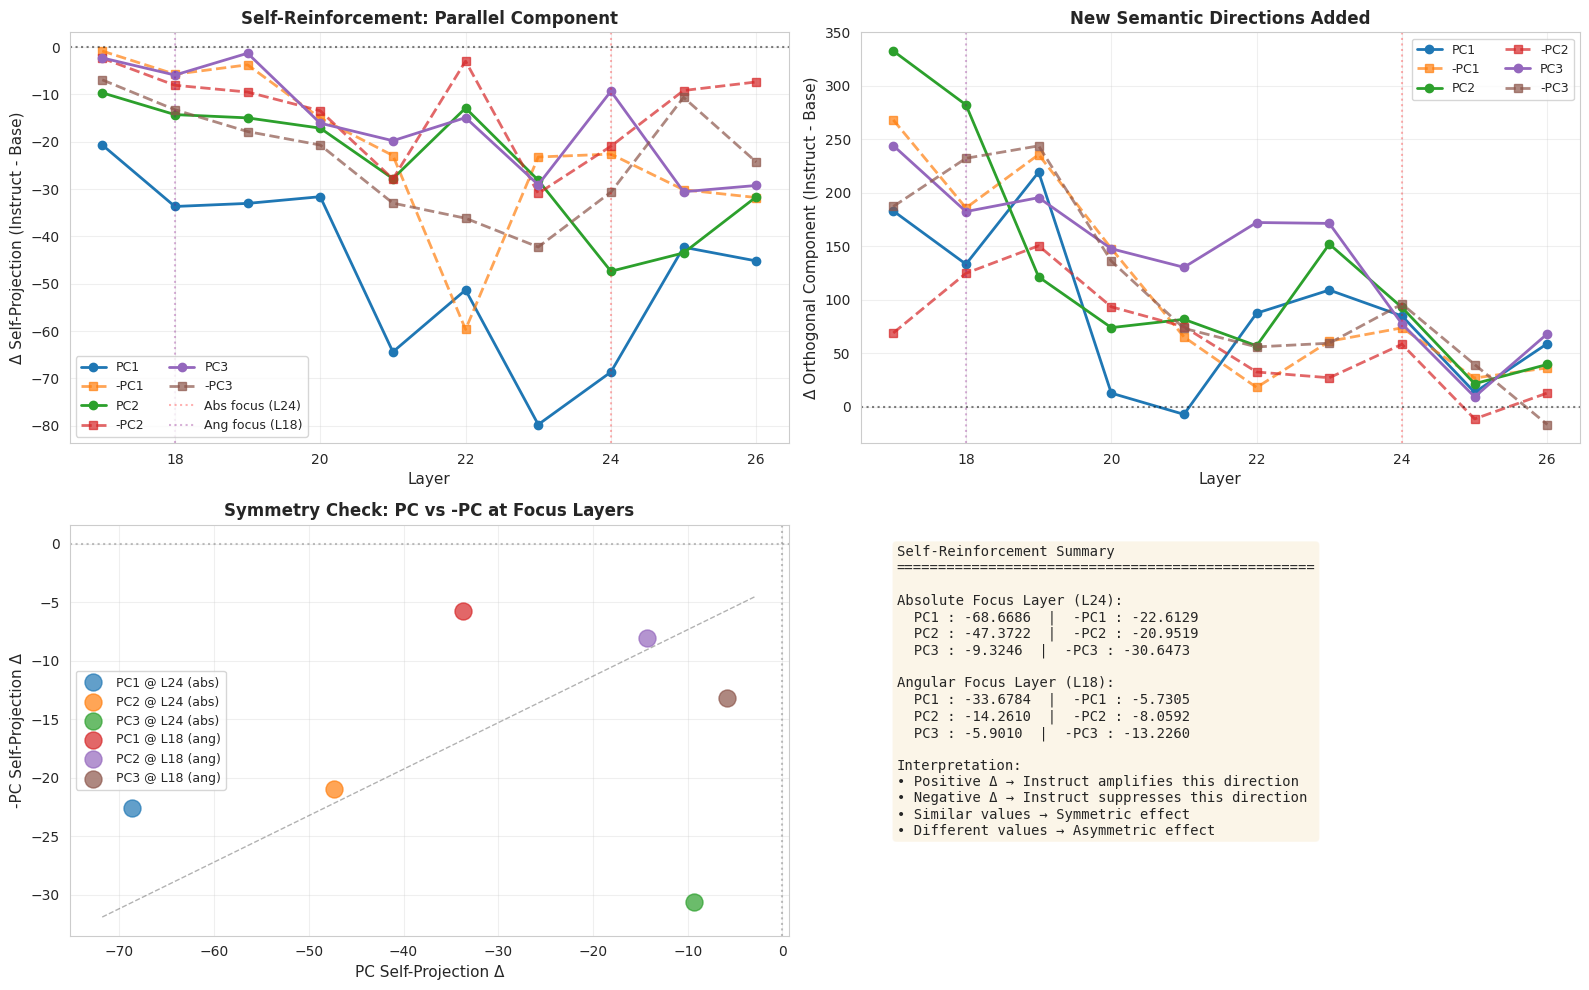

In [21]:
# Visualize PC self-reinforcement patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Get unique PC pairs (PC1 vs -PC1, etc.)
unique_pcs = sorted(set([name.replace('-', '') for name in pc_test_names]))

# Top left: Self-projection delta (parallel component change)
ax = axes[0, 0]
for pc in unique_pcs[:3]:  # Show first 3 PCs
    pos_data = pc_reinforce_df[pc_reinforce_df['pc'] == pc]
    neg_data = pc_reinforce_df[pc_reinforce_df['pc'] == f'-{pc}']
    
    ax.plot(pos_data['layer'], pos_data['proj_delta'], 'o-', label=f'{pc}', linewidth=2)
    ax.plot(neg_data['layer'], neg_data['proj_delta'], 's--', label=f'-{pc}', linewidth=2, alpha=0.7)

ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.3, label=f'Abs focus (L{int(focus_layer_absolute)})')
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.3, label=f'Ang focus (L{int(focus_layer_angular)})')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Δ Self-Projection (Instruct - Base)', fontsize=11)
ax.set_title('Self-Reinforcement: Parallel Component', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Top right: Orthogonal component delta (how much new directions added)
ax = axes[0, 1]
for pc in unique_pcs[:3]:
    pos_data = pc_reinforce_df[pc_reinforce_df['pc'] == pc]
    neg_data = pc_reinforce_df[pc_reinforce_df['pc'] == f'-{pc}']
    
    ax.plot(pos_data['layer'], pos_data['ortho_delta'], 'o-', label=f'{pc}', linewidth=2)
    ax.plot(neg_data['layer'], neg_data['ortho_delta'], 's--', label=f'-{pc}', linewidth=2, alpha=0.7)

ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.3)
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.3)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Δ Orthogonal Component (Instruct - Base)', fontsize=11)
ax.set_title('New Semantic Directions Added', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Bottom left: Compare PC1 vs -PC1 at focus layers
ax = axes[1, 0]
focus_layers_to_show = [int(focus_layer_absolute), int(focus_layer_angular)]
for layer_num in focus_layers_to_show:
    for pc in unique_pcs[:3]:
        pos_val = pc_reinforce_df[(pc_reinforce_df['pc'] == pc) & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        neg_val = pc_reinforce_df[(pc_reinforce_df['pc'] == f'-{pc}') & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        
        layer_label = f"L{layer_num} ({'abs' if layer_num == int(focus_layer_absolute) else 'ang'})"
        ax.scatter([pos_val], [neg_val], s=150, label=f'{pc} @ {layer_label}', alpha=0.7)

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--', alpha=0.3, linewidth=1)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('PC Self-Projection Δ', fontsize=11)
ax.set_ylabel('-PC Self-Projection Δ', fontsize=11)
ax.set_title('Symmetry Check: PC vs -PC at Focus Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Bottom right: Summary table
ax = axes[1, 1]
ax.axis('off')

# Create summary text
summary_text = "Self-Reinforcement Summary\n" + "="*50 + "\n\n"

for layer_num, layer_name in [(int(focus_layer_absolute), 'Absolute'), (int(focus_layer_angular), 'Angular')]:
    summary_text += f"{layer_name} Focus Layer (L{layer_num}):\n"
    for pc in unique_pcs[:3]:
        pos_proj = pc_reinforce_df[(pc_reinforce_df['pc'] == pc) & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        neg_proj = pc_reinforce_df[(pc_reinforce_df['pc'] == f'-{pc}') & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        
        summary_text += f"  {pc:4s}: {pos_proj:+.4f}  |  -{pc:4s}: {neg_proj:+.4f}\n"
    summary_text += "\n"

summary_text += "Interpretation:\n"
summary_text += "• Positive Δ → Instruct amplifies this direction\n"
summary_text += "• Negative Δ → Instruct suppresses this direction\n"
summary_text += "• Similar values → Symmetric effect\n"
summary_text += "• Different values → Asymmetric effect"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

## 4. Summary

This analysis reveals how instruction tuning modifies MLP transformations of PC vectors:

**Key Insights:**
- **Full MLP pass** reveals nonlinear transformation effects missed by linear analysis
- **Two types of change**:
  - **Absolute delta (L2 norm)**: Where magnitude of change is largest
  - **Angular delta (cosine distance)**: Where direction change is largest
- **Dual focus layers**: Automatically identified from data
  - May be the same layer (consistent transformation)
  - May differ (magnitude vs direction effects at different depths)
- **Semantic decomposition**: Projects changes onto role/trait vectors to reveal semantic meaning

**Interpretation:**
- **Large absolute delta** → Instruction tuning strongly amplifies/suppresses this transformation
- **Large angular delta** → Instruction tuning redirects the semantic direction
- **Different focus layers** → Suggests instruction tuning has depth-dependent effects
- **Projection patterns** → Show which semantic dimensions are specifically targeted